# CNN vs MLP on MNIST - Minimal Assignment

## 1. Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

## 2. Load and Preprocess MNIST

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [0,1] and add channel dimension
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

Train shape: (60000, 28, 28, 1), Test shape: (10000, 28, 28, 1)


## 3. Data Augmentation (Basic)

In [14]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

## 4. Build CNN Model (2 Conv + FC)

In [15]:
cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Build MLP Model (for comparison)

In [16]:
# Flatten images for MLP
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

mlp = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(28*28,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

mlp.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train CNN with Augmentation

In [17]:
history_cnn = cnn.fit(
    datagen.flow(x_train, y_train_cat, batch_size=512),
    epochs=5,
    validation_data=(x_test, y_test_cat),
    verbose=1
)

Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 511ms/step - accuracy: 0.5770 - loss: 1.3547 - val_accuracy: 0.9642 - val_loss: 0.1272
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 493ms/step - accuracy: 0.9212 - loss: 0.2616 - val_accuracy: 0.9770 - val_loss: 0.0783
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 500ms/step - accuracy: 0.9414 - loss: 0.1931 - val_accuracy: 0.9809 - val_loss: 0.0623
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 484ms/step - accuracy: 0.9517 - loss: 0.1563 - val_accuracy: 0.9799 - val_loss: 0.0693
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 492ms/step - accuracy: 0.9615 - loss: 0.1291 - val_accuracy: 0.9859 - val_loss: 0.0481


## 7. Train MLP (no augmentation)

In [18]:
history_mlp = mlp.fit(
    x_train_flat, y_train_cat,
    batch_size=128,
    epochs=10,
    validation_data=(x_test_flat, y_test_cat),
    verbose=1
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8336 - loss: 0.6031 - val_accuracy: 0.9483 - val_loss: 0.1723
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9571 - loss: 0.1450 - val_accuracy: 0.9654 - val_loss: 0.1131
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9722 - loss: 0.0934 - val_accuracy: 0.9725 - val_loss: 0.0926
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9794 - loss: 0.0687 - val_accuracy: 0.9730 - val_loss: 0.0877
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9846 - loss: 0.0523 - val_accuracy: 0.9752 - val_loss: 0.0805
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9860 - loss: 0.0438 - val_accuracy: 0.9748 - val_loss: 0.0843
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9896 - loss: 0.0345 - val_accuracy: 0.9738 - val_loss: 0.0880
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9915 - loss: 0.0277 - val_accuracy: 0.

## 8. Evaluate Both Models

In [19]:
test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test, y_test_cat, verbose=0)
test_loss_mlp, test_acc_mlp = mlp.evaluate(x_test_flat, y_test_cat, verbose=0)

print(f"CNN Test Accuracy: {test_acc_cnn:.4f}")
print(f"MLP Test Accuracy: {test_acc_mlp:.4f}")

CNN Test Accuracy: 0.9859
MLP Test Accuracy: 0.9771


## 9. Plot Accuracy Comparison

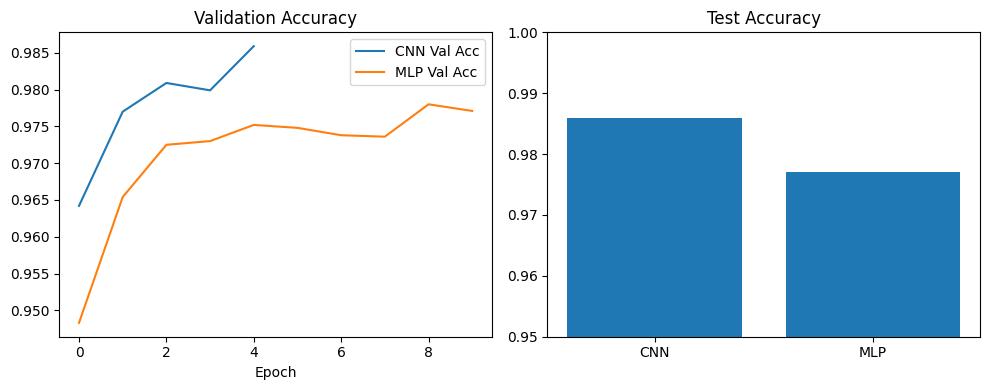

In [20]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val Acc')
plt.plot(history_mlp.history['val_accuracy'], label='MLP Val Acc')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['CNN', 'MLP'], [test_acc_cnn, test_acc_mlp])
plt.title('Test Accuracy')
plt.ylim(0.95, 1.0)

plt.tight_layout()
plt.show()